In [1]:
import pickle
import pandas as pd
import numpy as np

data = pickle.load(open('signals_archive/chunks_1s/df_chunks_1s.pkl', 'rb'))

In [2]:
from tqdm import tqdm
from librosa import display
import matplotlib.pyplot as plt
import librosa
import librosa.display

namespace = '1s_silence'

In [4]:
print(data.keys())

del data['Unnamed: 0']

print(data.keys())

Index(['Bandwidth', 'Description', 'Frequency', 'Location', 'Mode',
       'Modulation', 'Sample_audio', 'Signal_type', 'Waterfall_image',
       'chunks', 'imgs_path_low', 'imgs_path_high'],
      dtype='object')


KeyError: 'Unnamed: 0'

In [6]:
def extract_silence(path):
    y, sr = librosa.load(path)


    # And compute the spectrogram magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(y))

    # As a first step, we can plot the root-mean-square (RMS) curve
    rms = librosa.feature.rms(y=y)[0]
    # print(rms)
    times = librosa.frames_to_time(np.arange(len(rms)))

    threshold = 0.02
    # r_normalized = (rms - threshold) / np.std(rms)
    r_normalized = (rms - threshold)
    # print(rms - threshold)
    # print(np.std(rms))
    # print(r_normalized)
    p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
    # print(p)
    transition = librosa.sequence.transition_loop(2, [0.5, 0.6])
    # print(transition)
    full_p = np.vstack([1 - p, p])
    # print(full_p)

    states = librosa.sequence.viterbi_discriminative(full_p, transition)
    # print(p)
    # print(len(states))
    return p


In [7]:
# print(len(data['Sample_audio']))
silence_arr = []
for samples in tqdm(data['chunks']):
    tmp_silence_arr = []
    for sample in samples:
        sample = sample.replace('notebooks/', '')
        tmp_silence_arr.append(extract_silence(sample))
    silence_arr.append(tmp_silence_arr)


print(len(silence_arr))
# # audio_path = data['Sample_Audio'][43]
# tmp = []

# for i in tqdm(range(len(data['Sample_Audio']))):
# # for i in range(25, 28):
#     audio_path = data['Sample_Audio'][i]
#     # print(audio_path)
#     tmp.append(extract_silence(audio_path))

# data[namespace] = tmp

100%|██████████| 602/602 [11:29<00:00,  1.14s/it]602



In [9]:
with open('signals_archive/chunks_1s/df_chunks_1s.pkl', 'wb') as _file:
    pickle.dump(data, _file)

In [10]:
import sompylib3.sompy as SOM
from sompylib3.sompy import denormalize_by
import math

# data_features = [x for x in data[namespace]]
# silence_arr = np.array(silence_arr).reshape(np.array(silence_arr).shape[0], -1)
data_features = []
for silence in silence_arr:
    for inner_silence in silence:
        data_features.append(inner_silence)
print(np.array(data_features).shape)

m = 5 * math.sqrt(np.array(data_features).shape[0])

m = math.floor(math.sqrt(m))

print(m)

print('--map size--')
print('[', m,', ' , m, ']')
'''
try smaller
'''
map_size = [m, m]

sm = SOM.SOM('', data_features, mapsize = map_size, norm_method = 'var', initmethod='pca')
sm.init_map()
sm.train(trainlen=None, n_job = 1, shared_memory = 'no', verbose='on')

(19744, 44)
26
--map size--
[ 26 ,  26 ]

initialization method = pca, initializing..

initialization done in 0.032000 seconds

rough training...
radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 2

epoch: 1 ---> elapsed time:  0.152000, quantization error: 1.603144 

epoch: 2 ---> elapsed time:  0.143000, quantization error: 1.620249 


finetune training...
radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 2

epoch: 1 ---> elapsed time:  0.145000, quantization error: 1.209949 

epoch: 2 ---> elapsed time:  0.143000, quantization error: 1.063226 

Total time elapsed: 0.650000 secodns
final quantization error: 1.063226


clustering based on default parameters...


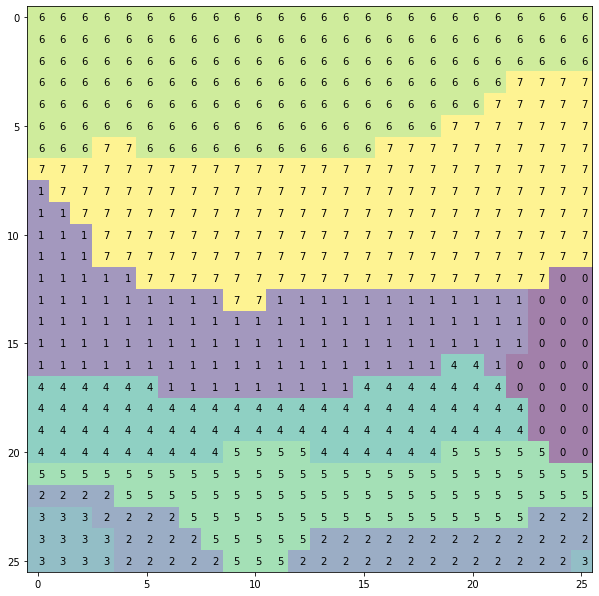

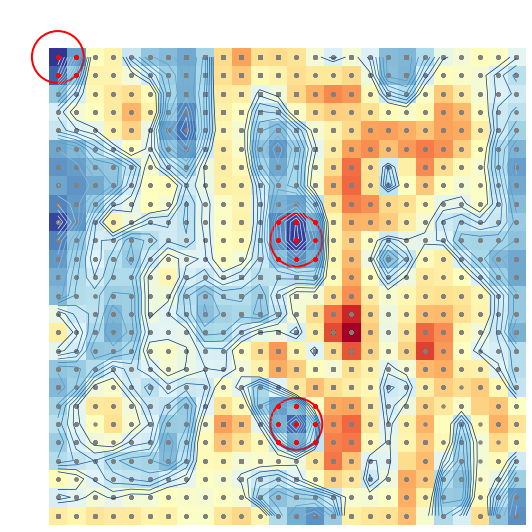

In [11]:
view2D  = sm.hit_map_cluster_number()
view2D  = sm.view_U_matrix()

In [12]:
data['silence'] = silence_arr


bmus = []
# print(np.asarray(data['fingerprints'][0]).shape)
for i in tqdm(range(len(data_features))):
    feature = data_features[i]
    # feature = np.asarray(feature)
    # print(feature.shape)
    # bmu = sm.project_data(np.asarray(feature).reshape(features_shape[0] * features_shape[1], -1))
    bmu = sm.project_data(np.asarray(feature).reshape(1, -1))

    # print(feature.shape)
    bmus.append(bmu.tolist())

tmp_bmus = [0] * len(data['silence'])
index = 0
j = 0
for fingerprint in data['silence']:
    tmp_bmus[index] = []
    for i in range(len(fingerprint)):
        tmp_bmus[index].append(bmus[j])
        j += 1
    index += 1

data['bmus'] = tmp_bmus

with open('signals_archive/chunks_1s/df_chunks_1s.pkl', 'wb') as _file:
    pickle.dump(data, _file)

100%|██████████| 19744/19744 [07:08<00:00, 46.06it/s]


In [13]:
import json

def convert(o):
    '''
        workaround from stackoverflow to prevent error
        when having data from numpy
    '''
    if isinstance(o, np.int64): return int(o)
    if isinstance(o, np.float64): return float(o)
    if isinstance(o, np.ndarray): return o.tolist()
    raise TypeError


headers = list(data.columns.values)
data_to_dict = {}
for header in headers:
    data_to_dict[header] = data[header].tolist()
    print(header)
    # print(type(data_to_dict[header][0][0]))

# tmp = []
# for fp in data_to_dict[namespace]:
#     tmp_1 = []
#     for val in fp:
#         # print(type(val))
#         tmp_1.append(float(val))
#     tmp.append(tmp_1)

# data_to_dict[namespace] = tmp
# del data_to_dict['fingerprints']
# remove NaNs
index = 0
for d in data_to_dict['Description']:
    if isinstance(d, str) == False:
        data_to_dict['Description'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Mode']:
    if isinstance(d, str) == False:
        data_to_dict['Mode'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Location']:
    if isinstance(d, str) == False:
        data_to_dict['Location'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Modulation']:
    if isinstance(d, str) == False:
        data_to_dict['Modulation'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Frequency']:
    if isinstance(d, str) == False:
        data_to_dict['Frequency'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Bandwidth']:
    if isinstance(d, str) == False:
        data_to_dict['Bandwidth'][index] = "NaN"
    index += 1


import json

# output_json = data.to_json(orient='columns')
parse_to_json = json.dumps(data_to_dict, default=convert)
with open('signals_archive/chunks_1s/df_chunks_1s_silence.json', 'w') as f:
    f.write(parse_to_json)

cb = sm.codebook[:]
codebook = {
    'data': cb.tolist(),
    'size': map_size
}

with open('signals_archive/chunks_1s/1s_silence_codebook.json', 'w') as _file:
    json.dump(codebook, _file)

Bandwidth
Description
Frequency
Location
Mode
Modulation
Sample_audio
Signal_type
Waterfall_image
chunks
imgs_path_low
imgs_path_high
silence
bmus
